# Segmenting and Clustering Neighborhoods in Toronto
_Week 3 Project_

**To Do:**
 * Create link to notebook using: https://nbviewer.jupyter.org/

**Goals:**
* Scrape neighborhood data from Wikipedia page
* Retrieve lat/lng coordinates for each neighborhood
* Explore and cluster neighborhoods

#### Import Required Libraries

In [207]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium

In [ ]:
# import Foursquare developer credentials
%run "credentials.py"

#### Scrape Wiki Page

In [21]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
# print(soup.prettify()) # Uncomment to view scraped HTML

In [22]:
table = soup.find("table", class_="wikitable")
table_body = table.tbody
table_rows = table_body.findAll("tr")

#### Process Table HTML

In [23]:
cols = ["PostalCode", "Borough", "Neighborhood"]
data = []

for row in table_rows:
    cells = row.findAll("td")
    if len(cells) != 0:
        postcode = cells[0].text.strip()
        borough = cells[1].text.strip()
        neighborhood = cells[2].text.strip()
        if borough != "Not assigned":
            if neighborhood == "Not assigned":
                neighborhood = borough
            data.append([postcode, borough, neighborhood])
df = pd.DataFrame(data)
df.columns = cols
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### Group by PostalCode

In [24]:
# Technique 1
df_grouped = df.groupby(['PostalCode','Borough'])['Neighborhood'].agg(lambda col: ', '.join(col))

# Technique 2
# df_grouped = df.groupby(['PostalCode','Borough']).Neighborhood.unique().apply(lambda x: ', '.join(x)).reset_index()

toronto = df_grouped.to_frame().reset_index()
toronto

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


**Check Number of Rows**

In [25]:
print("The Toronto dataframe has {} rows.".format(toronto.shape[0]))

The Toronto dataframe has 103 rows.


#### Get Coordinates of Postal Codes
(Imported from csv as geocoder did not work for me)

In [26]:
## Add two empty columns for lat/lng
toronto["Latitude"], toronto["Longitude"] = np.nan, np.nan

**Attempted to use Geocoder:**

In [27]:
import geocoder

In [28]:
def get_coords(postal_code):
    coords = None

    while (coords is None):
        g = geocoder.google("{}, Toronto, Ontario".format(postal_code))
        coords = g.latlng

    lat = coords[0]
    lng = coords[1]
    return lat, lng

In [29]:
## Apply get coords function to each postal code ** Did not work **
# toronto["Latitude"], toronto["Longitude"] = zip(*toronto["PostalCode"].apply(get_coords))

**Pulled Lat/Lngs from CSV**

In [30]:
coords = pd.read_csv("assets/Geospatial_Coordinates.csv").set_index("Postal Code")
coords.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [31]:
unique_postal_codes = toronto["PostalCode"].unique()
toronto = toronto.set_index("PostalCode")

for p in unique_postal_codes:
    toronto.loc[p, "Latitude"], toronto.loc[p, "Longitude"] = coords.loc[p, "Latitude"], coords.loc[p, "Longitude"]
    
toronto = toronto.reset_index()

In [32]:
toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### Get the Lat/Lng of Toronto

In [34]:
address = "Toronto, Ontario"

geolocator = Nominatim(user_agent="ca_user")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


#### Create Map Plotting Helper Function

In [35]:
def plot_locations(center_lat, center_lng, locations_df):
    toronto_map = folium.Map(location=[center_lat, center_lng], zoom_start=11)

    folium.vector_layers.CircleMarker(
        [center_lat, center_lng],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        tooltip="Toronto"
    ).add_to(toronto_map)

    for lat, lng, label in zip(locations_df["Latitude"], locations_df["Longitude"], locations_df["Neighborhood"]):
        folium.vector_layers.CircleMarker(
            [lat, lng],
            radius=3,
            color="blue",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup=label
        ).add_to(toronto_map)
        
    return toronto_map

#### Map All Neighborhoods

In [36]:
plot_locations(latitude, longitude, toronto)

#### For Simplicity & Speed, Let's Look at a Subset of the Boroughs

In [208]:
toronto_data = toronto[toronto["Borough"].str.contains("Toronto")]
print(toronto_data.shape)
toronto_data.head()

(38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


**Visualize Subset of Locations**

In [209]:
plot_locations(latitude, longitude, toronto_data)

#### Get Nearby Venues for Each Borough using Foursquare API

**Create URL & Send GET Request**

In [210]:
radius = 500
limit = 100

def get_nearby_venues(df):
    venues_list = []
    
    for lat, lng, label in zip(df["Latitude"], df["Longitude"], df["PostalCode"]): 
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, 
            radius, limit)
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        venues_list.append([(
            label,
            lat,
            lng,
            venue["venue"]["name"],
            venue["venue"]["location"]["lat"],
            venue["venue"]["location"]["lng"],
            venue["venue"]["categories"][0]["name"]
        ) for venue in results])
    
    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ["PostalCode", "BoroughLatitude", "BoroughLongitude", 
                             "VenueName", "VenueLatitude", "VenueLongitude", "VenueCategory"]
    
    return nearby_venues

In [211]:
nearby_venues = get_nearby_venues(toronto_data)

**Examine Results**

In [212]:
print(nearby_venues.shape)
print("There are {} unique venue categories.\n".format(len(nearby_venues["VenueCategory"].unique())))
nearby_venues.head()

(1700, 7)
There are 240 unique venue categories.



,PostalCode,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [213]:
nearby_venues.groupby("PostalCode").count()

,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,,,,,,
M4E,5,5,5,5,5,5
M4K,42,42,42,42,42,42
M4L,18,18,18,18,18,18
M4M,38,38,38,38,38,38
M4N,3,3,3,3,3,3
M4P,8,8,8,8,8,8
M4R,16,16,16,16,16,16
M4S,38,38,38,38,38,38
M4T,2,2,2,2,2,2


#### Use One-Hot Encoding to Convert Categories into Numerical Values

In [214]:
nearby_venues_onehot = pd.get_dummies(nearby_venues["VenueCategory"])
nearby_venues_onehot["PostalCode"] = nearby_venues["PostalCode"]

# Re-order columns
cols = [nearby_venues_onehot.columns[-1]] + list(nearby_venues_onehot.columns.values[:-1])
nearby_venues_onehot = nearby_venues_onehot[cols]

nearby_venues_onehot.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
nearby_venues_onehot.shape

(1700, 241)

#### Group by PostalCode to get Frequency

In [216]:
nearby_venues_grouped = nearby_venues_onehot.groupby("PostalCode").mean().reset_index()
nearby_venues_grouped

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.20000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,M4K,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.02381,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.023810
2,M4L,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,M4M,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.026316
4,M4N,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,M4P,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,M4R,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.062500
7,M4S,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,M4T,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,M4V,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.00,0.000000


#### Get Top Categories for each Postal Code

In [217]:
def get_top_categories(idx, num=5):
    top = nearby_venues_grouped.iloc[idx, 1:].T.reset_index()
    top.columns = ["VenueCategory", "Frequency"]
    top["Frequency"] = top["Frequency"].astype(float)
    top = top.sort_values("Frequency", ascending=False).set_index("VenueCategory").head(num)
    return top

In [218]:
example = get_top_categories(0)
example

,Frequency
VenueCategory,
Trail,0.2
Neighborhood,0.2
Health Food Store,0.2
Other Great Outdoors,0.2
Pub,0.2


**Create DataFrame for Top Categories**

In [219]:
cols = ["PostalCode"]
endings = ["st", "nd", "rd"]

for i in range(10):
    if i < 3:
        cols.append(str(i + 1) + endings[i] + " Most Common Category")
    else:
        cols.append(str(i + 1) + "th Most Common Category")

top_df = pd.DataFrame(columns=cols)
top_df["PostalCode"] = nearby_venues_grouped["PostalCode"]

**Populate DataFrame**

In [220]:
for idx, row in top_df.iterrows():
    top_df.iloc[idx, 1:] = get_top_categories(idx, 10).index.values

top_df.head()

,PostalCode,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,Trail,Neighborhood,Health Food Store,Other Great Outdoors,Pub,Accessories Store,Music Venue,Music Store,Museum,Monument / Landmark
1,M4K,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Bubble Tea Shop,Spa,Café,Caribbean Restaurant
2,M4L,Park,Gym,Sushi Restaurant,Sandwich Place,Brewery,Steakhouse,Fast Food Restaurant,Movie Theater,Fish & Chips Shop,Liquor Store
3,M4M,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,Bookstore,Stationery Store
4,M4N,Swim School,Park,Bus Line,Accessories Store,Nightclub,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark


**Examine Results**

In [221]:
top_df["1st Most Common Category"].value_counts()

Coffee Shop         14
Café                 6
Park                 2
Greek Restaurant     1
Jewelry Store        1
Pharmacy             1
Ice Cream Shop       1
Gift Shop            1
Pub                  1
Swim School          1
Pizza Place          1
Trail                1
Playground           1
Airport Terminal     1
Bar                  1
Yoga Studio          1
Hotel                1
Grocery Store        1
Breakfast Spot       1
Name: 1st Most Common Category, dtype: int64

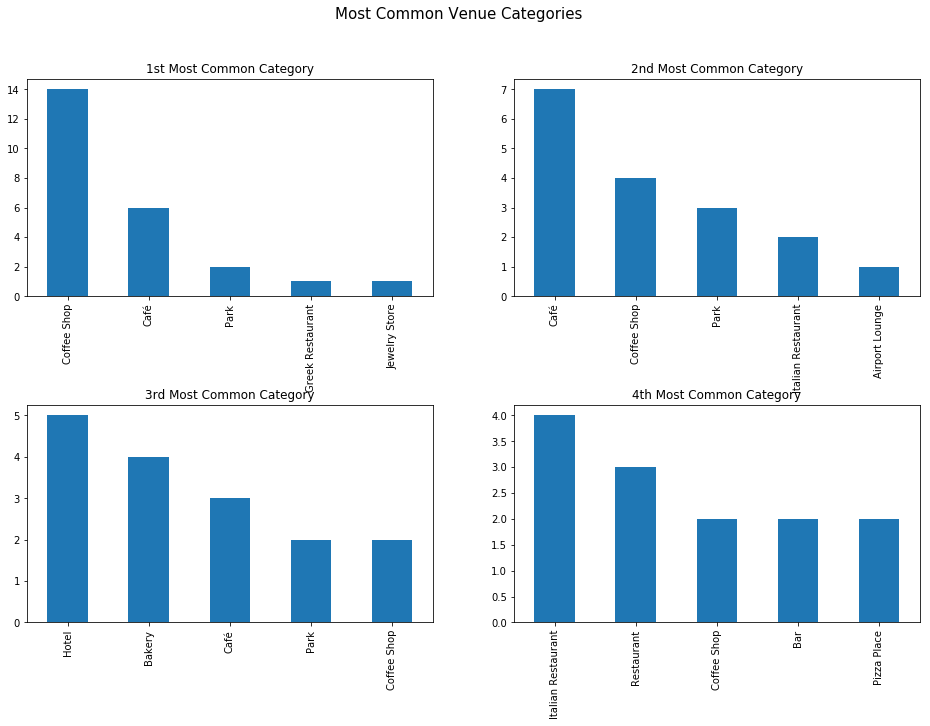

In [222]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(hspace = 0.5)

for i in range(4):
    if i < 2:
        top_df[top_df.columns[i+1]].value_counts().head().plot(kind="bar", ax=axs[0][i], title=top_df.columns[i+1])
    else:
        top_df[top_df.columns[i+1]].value_counts().head().plot(kind="bar", ax=axs[1][i%2], title=top_df.columns[i+1])

plt.suptitle("Most Common Venue Categories", fontsize=15)
plt.show()

#### Cluster Neighborhoods

In [232]:
n_clusters = 4

clustering_df = nearby_venues_grouped.drop(columns="PostalCode")

In [233]:
clustering_df.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.20000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,...,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [234]:
k_means = KMeans(n_clusters=n_clusters, random_state=0)
k_means.fit(clustering_df)

cluster_results = k_means.labels_
cluster_results

array([2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Format Final DataFrame
**Merge Cluster Results with Top Categories DataFrame**

In [235]:
result_df = top_df.copy()
result_df.insert(1, "Cluster", cluster_results)
result_df.head()

,PostalCode,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,2,Trail,Neighborhood,Health Food Store,Other Great Outdoors,Pub,Accessories Store,Music Venue,Music Store,Museum,Monument / Landmark
1,M4K,2,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Bubble Tea Shop,Spa,Café,Caribbean Restaurant
2,M4L,2,Park,Gym,Sushi Restaurant,Sandwich Place,Brewery,Steakhouse,Fast Food Restaurant,Movie Theater,Fish & Chips Shop,Liquor Store
3,M4M,2,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,Bookstore,Stationery Store
4,M4N,0,Swim School,Park,Bus Line,Accessories Store,Nightclub,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark


**Merge Location Data**

In [236]:
result_df = result_df.merge(toronto_data, how="inner", on="PostalCode")
result_df.head()

,PostalCode,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,Borough,Neighborhood,Latitude,Longitude
0,M4E,2,Trail,Neighborhood,Health Food Store,Other Great Outdoors,Pub,Accessories Store,Music Venue,Music Store,Museum,Monument / Landmark,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,2,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Bubble Tea Shop,Spa,Café,Caribbean Restaurant,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,2,Park,Gym,Sushi Restaurant,Sandwich Place,Brewery,Steakhouse,Fast Food Restaurant,Movie Theater,Fish & Chips Shop,Liquor Store,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,2,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,Bookstore,Stationery Store,East Toronto,Studio District,43.659526,-79.340923
4,M4N,0,Swim School,Park,Bus Line,Accessories Store,Nightclub,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Central Toronto,Lawrence Park,43.728020,-79.388790


**Rearrange Columns**

In [237]:
cols = result_df.columns.values
new_cols = list(cols[0:1]) + list(cols[-4:]) + list(cols[1:-4])
result_df = result_df[new_cols]
result_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Trail,Neighborhood,Health Food Store,Other Great Outdoors,Pub,Accessories Store,Music Venue,Music Store,Museum,Monument / Landmark
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Bubble Tea Shop,Spa,Café,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Park,Gym,Sushi Restaurant,Sandwich Place,Brewery,Steakhouse,Fast Food Restaurant,Movie Theater,Fish & Chips Shop,Liquor Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Gastropub,Yoga Studio,Chinese Restaurant,Bookstore,Stationery Store
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Swim School,Park,Bus Line,Accessories Store,Nightclub,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark


#### Examine Clusters

In [238]:
result_df[result_df["Cluster"] == 0].head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Swim School,Park,Bus Line,Accessories Store,Nightclub,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Building,Playground,Trail,Neighborhood,Music Venue,Music Store,Museum,Movie Theater,Accessories Store
23,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307,0,Jewelry Store,Sushi Restaurant,Trail,Park,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Nightclub,Middle Eastern Restaurant


#### Visualize Clusters

In [245]:
ys

[array([0, 1, 2, 3]),
 array([ 5,  7, 23, 89]),
 array([  10,   27,  268, 1309]),
 array([  15,   97, 1313, 6579])]

In [251]:
colors_array

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [252]:
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)
                         
x = np.arange(n_clusters)
colors_array = cm.rainbow(np.linspace(0, .8, len(x)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, postal_code, borough, cluster in zip(result_df["Latitude"], result_df["Longitude"], result_df["PostalCode"], result_df["Borough"], result_df["Cluster"]):
    label = "{}: {} (Cluster {})".format(postal_code, borough, cluster)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        fill=True,
        color=rainbow[cluster],
        fill_color=rainbow[cluster],
        fill_opacity=0.6,
        tooltip=label
    ).add_to(cluster_map)

cluster_map